## COMPETITION: Porto Seguro’s Safe Driver Prediction

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics


In [2]:
# Load cleaned train dataset
traindf = pd.read_csv("./traindf1.csv") #this assumes that traindf1 was created running EDA_Porto_Seguro_gh.R script in R
traindf

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0


### Prediction Iteration 1

In [3]:
# Store feature subset and target vector in X, y with id info to use later if needed
X = traindf.loc[:,traindf.columns != 'target']
y = traindf.iloc[:,0:2]

# splitting train and test data with same seed (random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #70%/30% splitting

#create classifier object
clf1 = XGBClassifier(random_state=1)

#train classifier
fit_model = clf1.fit(X_train.iloc[:,1:],y_train.iloc[:,1]) #train model with all features of train dataset except "id" feature

#create predictions vector and prediction probabilities of class 1
y_pred = fit_model.predict(X_test.iloc[:,1:]) #prediction vector with classes
y_pred_prob = fit_model.predict_proba(X_test.iloc[:,1:]) #prediction probabilities vector [P(0), P(1)]

# set up a 2-D array that has predictions and true (test) values side by side
pred_vs_true  = np.c_[y_pred,y_test.iloc[:,1]]
# convert it to dataframe to be readable in evaluation step
pred_vs_true_df = pd.DataFrame(data=pred_vs_true,columns = ["pred","true"]) 



### Evaluation (Iteration 1)

Create a confusion matrix to represent model's performance (using my own implementation, not sklearn's) - this is the same exercise as lab 6 (evaluation) - question 4:

In [4]:
# Create a confusion matrix to represent your model's performance (use your own implementation, not sklearn's)
# (this is the same exercise as lab 6 (evaluation) - question 4)

target_values = pd.unique(pred_vs_true_df["true"])
target_values = np.sort(target_values)

#create an empty dataframe that will be our confusion matrix to update later
confusion_matrix = pd.DataFrame(columns=target_values,index=target_values) 

#function that counts how many times [predicted values == true values] in a 2D array (predicted, true)
def compare_values(array,predicted,true):
    count = len(array.loc[(array["pred"]==predicted) & (array["true"]==true)]) 
    return count

#function to set up a matrix using compare_values function defined before
def set_matrix(pred_target_df):
    for y in range(0,len(target_values)): #for each unique value (level) of target feature 
        confusion_matrix.iloc[y] = [compare_values(pred_target_df,x,y) for x in target_values] # compare values for the different combination of predicted values (x) and "true" values (y)
    return confusion_matrix

confusion_matrix = set_matrix(pred_vs_true_df)
confusion_matrix

,0,1
0,172094,0
1,6470,0


In [5]:
#Confusion matrix metrics

# function to calculate recall per level in a confusion matrix
def calc_rec(cm):
    recs = [cm.iloc[i,i]/sum(cm.iloc[i,:]) for i in range(len(cm))]
    return recs

# function to calculate precision per level in a confusion matrix
def calc_prec(cm):
    precs = [cm.iloc[i,i]/sum(cm.iloc[:,i]) for i in range(len(cm))]
    return precs

#function to compute confusion matrix metrics
def cm_metrics(cm):
    acc = round(np.trace(cm)/cm.values.sum()*100,4) # accuracy
    print('Accuracy is ' + str(acc) + '%') # accuracy
    precs = calc_prec(cm)
    recs = calc_rec(cm)
    for i in range(len(cm)):
        print('Precision for "' + str(i) + '" class is ' + str(round(precs[i]*100,4)) + '%')
        print('Recall for "' + str(i) + '" class is '  + str(round(recs[i]*100,4)) + '%')

cm_metrics(confusion_matrix)

Accuracy is 96.3766%
Precision for "0" class is 96.3766%
Recall for "0" class is 100.0%
Precision for "1" class is nan%
Recall for "1" class is 0.0%


C:\Users\mtava\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


In [6]:
# Evaluate average class accuracy using harmonic mean (according to the module book, arithmetic means are more
#susceptible to influence of large outliers, which can inflate the apparent performance of a model. So I use harmonic mean)

# function to calculate recall per level in a confusion matrix
def calc_recall(cm):
    recalls = [cm.iloc[i,i]/sum(cm.iloc[i,:]) for i in range(len(cm))]
    return recalls

# function to calculate average class accuracy using harmonic mean given a confusion matrix as dataframe
def calc_avg_class_acc_hm(cm):
    recalls = calc_recall(cm)
    avg_class_acc_hm = 1/(1/len(recalls)*sum(np.reciprocal(recalls)))
    return avg_class_acc_hm

print("Average class accuracy (harmonic mean): " + str(round(calc_avg_class_acc_hm(confusion_matrix)*100,4)) + "%")


Average class accuracy (harmonic mean): 0.0%


C:\Users\mtava\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in reciprocal
  if sys.path[0] == '':


From the output above, Xgboost is basically unable to predict positive class label (imbalanced dataset).

In code below, I also use normalized Gini index evaluation (kaggle competition metric).

In [7]:
#https://www.kaggle.com/cpmpml/extremely-fast-gini-computation

def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    p = np.asarray(p)
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

print("Normalized gini coefficient: " + str(round(gini_normalizedc(y_test.iloc[:,1],y_pred_prob),4)))


Normalized gini coefficient: 0.2722


### Prediction Iteration 2 - Oversample rare class

I will use a different split of the dataset in an attemp to overcome the class imbalance problem. As suggested in Case Study of the of the module book (page 479), I will divide the training set with an equal proportion of claimers and non-claimers.
In this iteration, I will first oversample the test set to match the occurences of the rare class with the frequency of the majority class.


In [8]:
from sklearn.utils import resample #using sklearn resample

# get same instances of the previous train set with labels (and no id)
X_train_prev = pd.concat([X_train.iloc[:,1:], y_train.iloc[:,1]], axis=1)

claimers = X_train_prev[X_train_prev['target']==1] #get claimers subset
nonclaimers = X_train_prev[X_train_prev['target']==0] #get nonclaimers subset

# upsample rare class
claimers_upsampled = resample(claimers,
                          replace=True, # sample with replacement
                          n_samples=len(nonclaimers), # match number in majority class
                          random_state=1) # reproducible results

# get upsampled claimers subset and nonclaimers subset together to make a new balanced train dataset
train_upsampled = pd.concat([nonclaimers, claimers_upsampled])

# get new X_train and y_train
X_train2 = train_upsampled.loc[:,train_upsampled.columns != 'target']
y_train2 = train_upsampled.iloc[:,-1]

#train classifier (same classifier of first iteration but with different sampling)
fit_model2 = clf1.fit(X_train2,y_train2)

#create predictions vector and prediction probabilities. I will predict X_test instances ("unseen" instances)
y_pred2 = fit_model2.predict(X_test.iloc[:,1:]) #prediction vector with classes
y_pred_prob2 = fit_model2.predict_proba(X_test.iloc[:,1:]) #prediction probabilities vector [P(0), P(1)]

pred_vs_true2  = np.c_[y_pred2,y_test.iloc[:,1]] # set up a 2-D array that has predictions and true (test) values side by side
pred_vs_true_df2 = pd.DataFrame(data=pred_vs_true2,columns = ["pred","true"]) # convert it to dataframe to be readable by evaluation algorithm



In [ ]:
print(y_train)

### Evaluation (Iteration 2) - Oversample rare class

In [9]:
confusion_matrix2 = set_matrix(pred_vs_true_df2)
confusion_matrix2

,0,1
0,107865,64229
1,2828,3642


In [10]:
cm_metrics(confusion_matrix2)

Accuracy is 62.4465%
Precision for "0" class is 97.4452%
Recall for "0" class is 62.678%
Precision for "1" class is 5.3661%
Recall for "1" class is 56.2906%


In [11]:
print("Average class accuracy (harmonic mean): " + str(round(calc_avg_class_acc_hm(confusion_matrix2)*100,4)) + "%")

Average class accuracy (harmonic mean): 59.3128%


In [12]:
print("Normalized gini coefficient: " + str(round(gini_normalizedc(y_test.iloc[:,1], y_pred_prob2),4)))

Normalized gini coefficient: 0.2739


### Prediction Iteration 3 - Undersample majority class

In this iteration I will also divide the training set with an equal proportion of claimers and non-claimers but undersampling the majority class, i.e., randomly removing majority class instances to reach a balanced dataset.

In [13]:
# majority class undersampling
nonclaimers_undersampled = resample(nonclaimers,
                          replace=False, # sample without replacement
                          n_samples=len(claimers), # match number in majority class
                          random_state=1) # reproducible results

# get sampled claimers subset and undersampled nonclaimers subset together to make a new balanced train dataset
train_undersampled = pd.concat([nonclaimers_undersampled, claimers])

# get new X_train and y_train
X_train3 = train_undersampled.loc[:,train_undersampled.columns != 'target']
y_train3 = train_undersampled.iloc[:,-1]

#train classifier (same classifier of first iteration but with different sampling)
fit_model3 = clf1.fit(X_train3,y_train3)

#create predictions vector and prediction probabilities. I will predict X_test instances ("unseen" instances)
y_pred3 = fit_model3.predict(X_test.iloc[:,1:]) #prediction vector with classes
y_pred_prob3 = fit_model3.predict_proba(X_test.iloc[:,1:]) #prediction probabilities vector [P(0), P(1)]

pred_vs_true3 = np.c_[y_pred3,y_test.iloc[:,1]] # set up a 2-D array that has predictions and true (test) values side by side
pred_vs_true_df3 = pd.DataFrame(data=pred_vs_true3,columns = ["pred","true"]) # convert it to dataframe to be readable by evaluation algorithm



### Evaluation (Iteration 3) - Undersample majority class

In [14]:
confusion_matrix3 = set_matrix(pred_vs_true_df3)
confusion_matrix3

,0,1
0,107525,64569
1,2865,3605


In [15]:
cm_metrics(confusion_matrix3)

Accuracy is 62.2354%
Precision for "0" class is 97.4047%
Recall for "0" class is 62.4804%
Precision for "1" class is 5.2879%
Recall for "1" class is 55.7187%


In [16]:
print("Average class accuracy (harmonic mean): " + str(round(calc_avg_class_acc_hm(confusion_matrix3)*100,4)) + "%")

Average class accuracy (harmonic mean): 58.9061%


In [17]:
print("Normalized gini coefficient: " + str(round(gini_normalizedc(y_test.iloc[:,1], y_pred_prob3),4)))

Normalized gini coefficient: 0.2638


From the outputs above, either oversampling or undersampling results in significant improvement of the algorithms' performance metrics. Xgboost has proven to outperform other algorithms tested previously (SGD Classifier, Decision Trees, Random Forest). The fact that both precision and normalized gini coefficient are higher for a dataset that has its rare class oversampled suggests that the loss of information in an undersampled dataset is penalising the algorithm.

### Optimization



A trained XGBoost model automatically calculates feature importance on a predictive modeling problem. I will explore the built-in Plot Importance feature and then compute a feature selection also with built-in feature Importance Scores.
I will work with the oversampled dataset that I used previously on Iteration 2 once this resulted in better performance metrics.

The information regarding built-in functions for feature selection using xgboost were obtained in https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [18]:
#import libraries
from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from numpy import sort

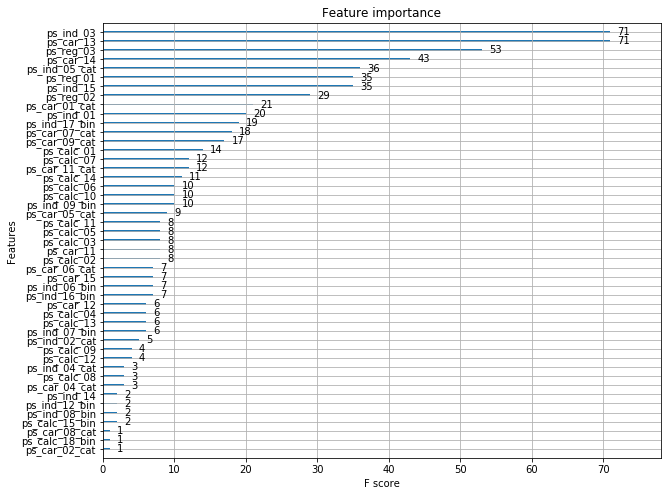

In [26]:
#plotting features importance by F score
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(fit_model2,ax=ax)
plt.show()

From plot above we can see that there are features with a big difference concerning its importance, which suggests that feature selection might be useful to improve performance metrics.


In code block below, I set up a function to predict and evaluate an xgboost classifier given a threshold of feature importance.

In [27]:
#create a vector of thresholds with feature importances
thresholds = sort(fit_model2.feature_importances_)

#create a function to train and evaluate using a subset of features given a threshold of importance
def evaluate_feature_reduction(thresh):
    
    ### Feature reduction logic ###
    
    # create selection object to select features above "thresh" importance level
    selection = SelectFromModel(fit_model2, threshold=thresh, prefit=True) #fit_model2 once it is more sensitive to rare class
    
    # select train dataset only with features above "thresh" importance level
    X_train_subset = selection.transform(X_train2) #X_train2 (oversampled training set)
    
    selection_clf = XGBClassifier(random_state=1) #create classifier object
    selection_fit_model = selection_clf.fit(X_train_subset,y_train2) #train classifier with feature reduction
    
    # select test dataset only with features above "thresh" importance level
    X_test_subset = selection.transform(X_test.iloc[:,1:])

    #create predictions vector and prediction probabilities. I will predict X_test instances ("unseen" instances)
    y_pred_subset = selection_fit_model.predict(X_test_subset) #prediction vector with classes
    y_pred_prob_subset = selection_fit_model.predict_proba(X_test_subset) #prediction probabilities vector [P(0), P(1)]

    pred_vs_true_subset = np.c_[y_pred_subset,y_test.iloc[:,1]] # set up a 2-D array that has predictions and true (test) values side by side
    pred_vs_true_df_subset = pd.DataFrame(data=pred_vs_true_subset,columns = ["pred","true"]) # convert it to dataframe to be readable by evaluation algorithm
    
    ### Evaluation logic ###
    
    confusion_matrix_subset = set_matrix(pred_vs_true_df_subset)
    n_features = X_train_subset.shape[1]
    avg_class_accuracy_hm = round(calc_avg_class_acc_hm(confusion_matrix_subset)*100,4)
    normalized_gini = round(gini_normalizedc(y_test.iloc[:,1], y_pred_prob_subset),4)
    threshold = thresh
    return n_features, avg_class_accuracy_hm, normalized_gini, thresh
    
fr_results = [evaluate_feature_reduction(thresh) for thresh in thresholds]

fr_n_features = [x[0] for x in fr_results] #get number of features used in prediction
fr_avg_class_accuracy_hm = [x[1] for x in fr_results]  #get average class accuracy 
fr_normalized_gini = [x[2] for x in fr_results] #get normalized gini index
fr_threshold = [x[3] for x in fr_results] #get threshold to use later



In plots below, I compute average class accuracy and normalized gini coefficient for each subset of features. Given that the subset of features was chosen based on importance threshold and there are seven features with importance equal to zero, this resulted in the same 56 features (all features) being chosen for the first 8 iterations and consequently outputing the same performance metrics - hence the gap observed from n=55 to n=47 in plots below.

Feature reduction results - average class accuracy:

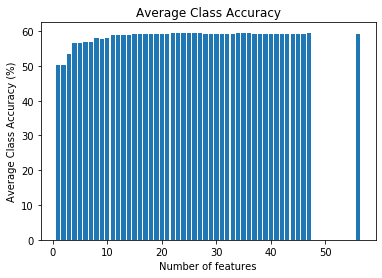

In [28]:
plt.bar(fr_n_features,fr_avg_class_accuracy_hm)
plt.title('Average Class Accuracy')
plt.xlabel('Number of features')
plt.ylabel('Average Class Accuracy (%)')
plt.show()

Feature reduction results - normalized gini coefficient:

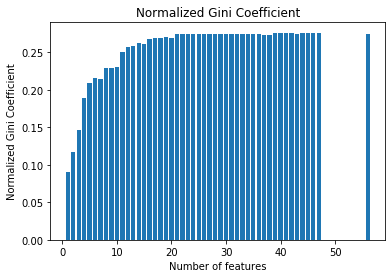

In [29]:
# plot feature reduction results - normalized gini coefficient
plt.bar(fr_n_features,fr_normalized_gini)
plt.title('Normalized Gini Coefficient')
plt.xlabel('Number of features')
plt.ylabel('Normalized Gini Coefficient')
plt.show()

From the outputs below I conclude that feature reduction has little impact in both average class accuracy and normalized gini coefficient.

However, there is an optimal subset of features that produce the highest gini coefficient that I can retrieve to make better predictions based on this criteria.

In [37]:
#obtain index of maximum gini coefficient
max_index = fr_normalized_gini.index(max(fr_normalized_gini))
max_threshold = fr_threshold[max_index]
max_ginic = fr_normalized_gini[max_index]
max_avg_class_accuracy_hm = fr_avg_class_accuracy_hm[max_index]
print("Maximum normalized gini coefficent: "+ str(max_ginic) +" for " + str(fr_n_features[max_index]) + " features ("+ str(round(max_avg_class_accuracy_hm,2))+"%)." )

Maximum normalized gini coefficent: 0.2762 for 47 features (59.34%).


Build predictive model based on maximum gini coefficient obtained after feature reduction.

In [31]:
# create selection object to select features above "max_threshold" importance level
selection = SelectFromModel(fit_model2, threshold=max_threshold, prefit=True) #fit_model2 once it is more sensitive to rare class
    
# select train dataset only with features above "max_thresh" importance level
X_train_subset = selection.transform(X_train2) #X_train2 (oversampled training set)
    
selection_clf = XGBClassifier(random_state=1) #create classifier object
selection_fit_kaggle_model = selection_clf.fit(X_train_subset,y_train2) #train classifier with feature reduction

### Kaggle Prediction

In [32]:
#load kaggle test dataset
testdf = pd.read_csv("./testdf1.csv")

# select kaggle test dataset only with features above "thresh" importance level
kaggle_test_subset = selection.transform(testdf.iloc[:,1:])

#create prediction probabilities 2D vector. I will predict kaggle_test_subset
kaggle_pred_prob_subset = selection_fit_kaggle_model.predict_proba(kaggle_test_subset) #prediction probabilities vector [P(0), P(1)]

preds_index = testdf.iloc[:,0] #get indexes id from testdf
preds_test = np.around(kaggle_pred_prob_subset[:,1],4) # round probability predictions vector to 4 decimal places

#create dataframe with indexes and probabilities
output = pd.DataFrame({'Id': preds_index, 'target': preds_test})

# save to txt
np.savetxt("submission.csv", output.values, delimiter=",", fmt=['%d','%1.4f'], header="id,target",comments='')
